## Template for providing an AlphaFold complex and couplings from evcouplings pipeline to generate a contact-coupling map

- receive a contact map that marks residues in a given atomic distance in the complex
    - some contacts are intramolecular only (blue)
    - others can be between homomeric chains that assemble into a higher-order structure (orange)
- intermolecular couplings between the different complex chains are plotted on the sides

Handwork must be done to tune each script to the according complex, given the different stochiometries / chain names / number of coupling files. But usually filling in the blanks and toying with should work.

In [1]:
#initialize
print('Importing libraries...')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn', turns off some warnings from pandas
%matplotlib inline

# enable svg export with editable text
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

from evcouplings.couplings import read_raw_ec_file
from evcouplings.compare import (
    pdb, DistanceMap, intra_dists,
    multimer_dists, coupling_scores_compared
)
from evcouplings.compare.pdb import ClassicPDB
from evcouplings.visualize import plot_contact_map, plot_context, complex_contact_map, find_boundaries

print('Libraries imported!')

#run a function definition script that is saved at a specified location
%run "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/Jupyter Notebook scripts for data analysis/funcdef.py"

Importing libraries...
Libraries imported!
Defining functions...
Functions initalized!


# INPUT PREPARATION

In [2]:
# load pdbs and evcouplings residue couplings
# pass an input folder as a string and a list of filenames with .pdb ending

PDB_folder = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/PDB"
PDB_files = [
            'spoVAAB_2_2.pdb', 
            ]

# specificy the chain IDs (A,B,C...) in the PDB file whose ID you want to analyze as a dictionary, 
# where the key is the PDB filename
# and the values is a list of chain name strings whose distances you want to compute as a two-element list
# e.g. PDB_files[0]:[['A','B'],['E','F']]...

# Be sure to catch all permutations of chain combinations in a multimer complex to have a symmetric plot!

chains_monomer = {
    PDB_files[0]:['A','B','C','D']
}


chains_intra = { #for homomer contacts
    PDB_files[0]:[
                  ['A','B'],
                  ['B','A'],
                  ['C','D'],
                  ['D','C'],
    ]
}
chains_inter = { #for heteromer contacts, which will be aggregated
    PDB_files[0]:[
                  ['A','C'],
                  ['A','D'],
                  ['B','C'],
                  ['B','D'],
                  ['C','A'],
                  ['C','B'],
                  ['D','A'],
                  ['D','B'],
                 ],
}

# pass an input folder as a string and a list of .csv files with evcouplings of the complex
# you want to use the _longrange.csv files as they exclude couplings between residues closer together than 4 residues
ecs_folder_inter = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVcouplings of spore germination protein pairs"
ecs_files_inter = [
            '20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv',
            ]

ecs_folder_intra = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVcouplings of spore germination protein monomers"
ecs_files_intra = [
            'SpoVAA/P40866_b0.3/couplings/P40866_b0.3_CouplingScores_longrange.csv',
            'SpoVAB/P40867_b0.3/couplings/P40867_b0.3_CouplingScores_longrange.csv',
            ]

# DATA LOADING AND PROCESSING

In [3]:
# load files and store in dicts with filenames as keys
PDB_list = {}
for file in PDB_files:
    PDB_list[file] = ClassicPDB.from_file(PDB_folder+'/'+file,file_format="pdb")
    
ec_list = {}
for file in ecs_files_inter:
    ecs = pd.read_csv(ecs_folder_inter+'/'+file)
    ec_list[file] =  ecs

ec_list_intra = {}
for file in ecs_files_intra:
    ecs = pd.read_csv(ecs_folder_intra+'/'+file)
    ec_list_intra[file] =  ecs

In [4]:
monomer_distancemaps = {}
intra_distancemaps = {}
inter_distancemaps = {}

for file in PDB_files: #loop over all PDB files
    print('>'+str(file))
    for monomer in chains_monomer[file]:         
            #print('Monomer chain: '+str(monomer))
            monomer_distancemaps[str(file)+'/'+str(monomer)]=distmap_calc(monomer, PDB_list[str(file)]) #get distmap
    
    if str(file) in chains_intra: #loop over all chains specified if present in input
        for intra in chains_intra[file]:         
            #print('INTRA molecular chain pair: '+str(intra))
            intra_distancemaps[str(file)+'/'+''.join(intra)]=distmap_calc(intra, PDB_list[str(file)]) #get distmap
            
    if str(file) in chains_inter:
        for inter in chains_inter[file]:       
            #print('INTER molecular chain pair: '+str(inter))
            inter_distancemaps[str(file)+'/'+''.join(inter)]=distmap_calc(inter, PDB_list[str(file)])
            

>spoVAAB_2_2.pdb


In [5]:
# split the evcouplings table into intramolecular and intermolecular couplings, 
# based on which chain they belong to

intra_A = {}
intra_B = {}
inter = {}
for file in ecs_files_inter: #loop over all ec tables get monomer couplings (A/B) or heteromer (A_B) couplings
    print('>'+file)
    ec_i = ec_list[file]
    ec_i['size']=ec_i['probability']
    ec = ec_i
    
    ec_A = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'A_1')]
    ec_B = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'B_1')]
    ec_het = ec.loc[ec['segment_i'] != ec['segment_j']]
    
    ec_A.loc[:,'size'] = rescale_size(ec_A, 'size')
    ec_B.loc[:,'size'] = rescale_size(ec_B, 'size')
    ec_het.loc[:,'size'] = rescale_size(ec_het, 'size')
    
    intra_A[str(file)] = ec_A
    intra_B[str(file)] = ec_B
    inter[str(file)] = ec_het
    
for file in ecs_files_intra:
    print('>'+file)
    ec_i = ec_list_intra[file]
    ec_i['size']=ec_i['probability']
    ec = ec_i
    
    ec_A = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'A')]
    ec_A.loc[:,'size'] = rescale_size(ec_A, 'size') 
    intra_A[str(file)] = ec_A

>20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv
>SpoVAA/P40866_b0.3/couplings/P40866_b0.3_CouplingScores_longrange.csv
>SpoVAB/P40867_b0.3/couplings/P40867_b0.3_CouplingScores_longrange.csv


# This is the output of the data prep! 
### For plotting, you must now assign each coupling in the individual files the associated chain(s) and aggregate distance maps, if you are dealing with a multimeric assembly. Take a screenshot of this list and copy it to a txt file so you can easily copy out of it.
### To index, use these key values as strings to query the respective coupling files and distance maps between two chains from the according dictionaries.

In [6]:
print('\t> Coupling files for monomer A (intra_A[])')
print('\n'.join(list(intra_A.keys())))
print('\t> Coupling files for monomer B (intra_B[])')
print('\n'.join(list(intra_B.keys())))
print('\t> Coupling files for A/B, (inter[])')
print('\n'.join(list(inter.keys())))
print('\n')
print('\t> Distance matrices for monomer chains (monomer_distancemaps[])')
print('\n'.join(list(monomer_distancemaps.keys())))
print('\t> Distance matrices for intramolecular distances in chains (intra_distancemaps[])')
print('\n'.join(list(intra_distancemaps.keys())))
print('\t> Distance matrices for intermolecular distances in chains (inter_distancemaps[])')
print('\n'.join(list(inter_distancemaps.keys())))

	> Coupling files for monomer A (intra_A[])
20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv
SpoVAA/P40866_b0.3/couplings/P40866_b0.3_CouplingScores_longrange.csv
SpoVAB/P40867_b0.3/couplings/P40867_b0.3_CouplingScores_longrange.csv
	> Coupling files for monomer B (intra_B[])
20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv
	> Coupling files for A/B, (inter[])
20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv


	> Distance matrices for monomer chains (monomer_distancemaps[])
spoVAAB_2_2.pdb/A
spoVAAB_2_2.pdb/B
spoVAAB_2_2.pdb/C
spoVAAB_2_2.pdb/D
	> Distance matrices for intramolecular distances in chains (intra_distancemaps[])
spoVAAB_2_2.pdb/AB
spoVAAB_2_2.pdb/BA
spoVAAB_2_2.pdb/CD
spoVAAB_2_2.pdb/DC
	> Distance matrices for intermolecular distances in chains (inter_distancemaps[])
spoVAAB_2_2.pdb/AC
spoVAAB_2_2.pdb/AD
spoVAAB_2_2.pdb/BC
spoVAAB_2_2.pdb

# This is where you need to most likely edit the data and plot by hand depending on what you want to do.
### There are just too many special cases to write a general script. You will have to set up the plotting area (the number of subplots) and pass some general parameters.

In [7]:
# optional, depending on multimercomplex topology: aggregate the distance maps for multimers to put all multi-chain
# contacts into a single distance map, passed to the plotting function
# tip: you can pass all the values in a dict as **kwargs to the aggregation by *list(___distancemaps.values())

agg_intra_distancemapA = DistanceMap.aggregate(
    intra_distancemaps['spoVAAB_2_2.pdb/AB'],
    intra_distancemaps['spoVAAB_2_2.pdb/BA'],    
)

agg_intra_distancemapB = DistanceMap.aggregate(
    intra_distancemaps['spoVAAB_2_2.pdb/CD'],
    intra_distancemaps['spoVAAB_2_2.pdb/DC']
)

agg_inter_distancemap = DistanceMap.aggregate(*list(inter_distancemaps.values()))


P:\Programme\Anaconda\lib\site-packages\evcouplings\compare\distances.py:701: RuntimeWarning: All-NaN slice encountered
  agg_mat = agg_func(new_mat, axis=0)


# Prepare the plot

In [8]:
# pass the number of proteins in the plot, making an nxn grid that you have to fill with the data
num_chains = 2
# distance threshold in Angstrom for plotting
dist_thresh = 5
# probability cutoff for couplings plotting (only plot with a probability larger than this value)
Pcutoff = 0.9

In [9]:
# here you will need to add the corresponding couplings and distance maps
# use 'structure' to plot the whole thing because AlphaFold PDBs contain entire protein in our case

intraA_boundaries = boundary_returner_intra('structure',
                                     intra_A['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'],
                                     monomer_distancemaps['spoVAAB_2_2.pdb/A'])
                                    
intraB_boundaries = boundary_returner_intra('structure',
                                     intra_B['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'],
                                     monomer_distancemaps['spoVAAB_2_2.pdb/C'])
inter_boundaries = boundary_returner_inter(intraA_boundaries, intraB_boundaries)

# Calculate the length ratios of the monomers that scale the plot axes - be sure to have all in this
monA_len = intraA_boundaries[0][1] - intraA_boundaries[0][0]
monB_len = intraB_boundaries[0][1] - intraB_boundaries[0][0]

ratios = []

# you will need to append as many ratios to the list as you num_chains - then the plot automatically scales the axes on the grid
ratios.append(monA_len / (monA_len + monB_len))
ratios.append(monB_len / (monA_len + monB_len))


# Make the plot with inputs from above

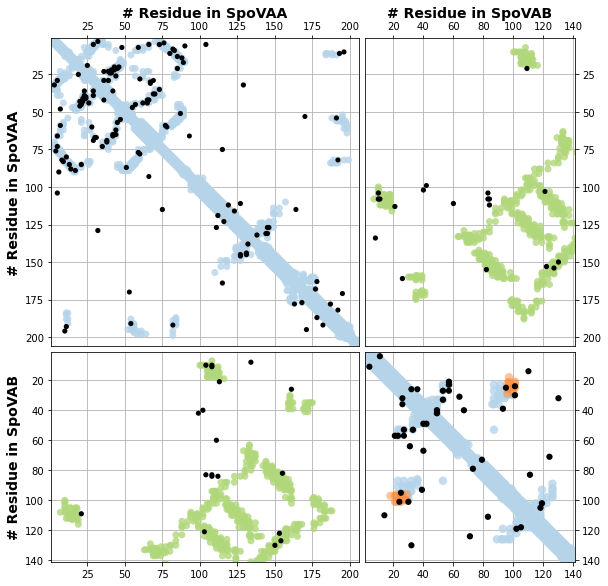

In [10]:
fig = plt.figure(figsize=(9,9))

# create the grid for plotting
gs = gridspec.GridSpec(
        num_chains, num_chains, width_ratios=ratios,
        height_ratios=ratios
)

# create a list of axes to run through with according axes scaling
ax = [None]*num_chains**2 
for i in range(0,num_chains**2,1):
    ax[i] = plt.subplot(gs[i])
    
    ax[i].grid(True, which='major') #gridlines under plot so it's easier to trace contacts
    ax[i].set_axisbelow(True)
                        
    #ax[i].annotate('ax'+str(i),(0.5, 0.5)) #you can use this to see which ax is which
    
# format plotting by passing kwargs to function as dict
STYLE_CONTACT = {
    "edgecolor": "none",
    "c": "#b6d4e9",
    "alpha": 0.8,
    "s": 100,
}

STYLE_CONTACT_MULTIMER = {
    "edgecolor": "none",
    "c": "#fc8c3b",
    "alpha": 0.5,
    "s": 100,
}

STYLE_CONTACT_INTER = {
    "edgecolor": "none",
    "c": "#b1d77b",
    "alpha": 0.8,
    "s": 100,
}

STYLE_EC = {
    "edgecolor": "none",
    "c": "black",
    "s": 75,
}
    
# contact map plotting per each ax
# to reverse the ecs and contact maps for transposed interaction plots in the top right corners, 
# - .rename(columns={"i": "j", "j": "i"}) for the ecs
# - .transpose() the distancemap
# - list(reversed(boundaries)) to invert the axis dimensions
# - symmetric=False, multimer = None
# you can copy and paste the plots but must edit the according input data and axis information

plot_contact_map( #A
            Pthresh(intra_A['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'],Pcutoff), 
            monomer_distancemaps['spoVAAB_2_2.pdb/A'],
            agg_intra_distancemapA,
            ax=ax[0], symmetric=True, margin = 0,
            distance_cutoff = dist_thresh, boundaries = intraA_boundaries,
            multimer_style=STYLE_CONTACT_MULTIMER, monomer_style = STYLE_CONTACT, ec_style = STYLE_EC
)
plot_contact_map( #inter in bottom left
            Pthresh(inter['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'],Pcutoff), 
            agg_inter_distancemap,
            ax=ax[2], symmetric=False, multimer = None, margin = 0,
            distance_cutoff = dist_thresh, boundaries = inter_boundaries, 
            monomer_style = STYLE_CONTACT_INTER, ec_style = STYLE_EC
)
plot_contact_map( #inter in top right, transpose data
            Pthresh(inter['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'].rename(
                columns={"i": "j", "j": "i"}),Pcutoff), 
            agg_inter_distancemap.transpose(),
            ax=ax[1], symmetric=False, multimer = None, margin = 0,
            distance_cutoff = dist_thresh, boundaries = list(reversed(inter_boundaries)),
            monomer_style = STYLE_CONTACT_INTER, ec_style = STYLE_EC
)
plot_contact_map( #B
            Pthresh(intra_B['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'],Pcutoff), 
            monomer_distancemaps['spoVAAB_2_2.pdb/C'],
            agg_intra_distancemapB,
            ax=ax[3], symmetric=True, margin = 0,
            distance_cutoff = dist_thresh, boundaries = intraB_boundaries,
            multimer_style=STYLE_CONTACT_MULTIMER, monomer_style = STYLE_CONTACT, ec_style = STYLE_EC
)

# some custom gusto with the axis labelling
ax[1].yaxis.set_ticks_position('right')
ax[2].xaxis.set_ticks_position('bottom')
ax[3].xaxis.set_ticks_position('bottom')
ax[3].yaxis.set_ticks_position('right')

ax[0].set_xlabel('# Residue in SpoVAA', fontsize = 14, fontweight = 'bold')
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('# Residue in SpoVAA', fontsize = 14, fontweight = 'bold')
ax[0].yaxis.set_label_position('left')

ax[1].set_xlabel('# Residue in SpoVAB', fontsize = 14, fontweight = 'bold')
ax[1].xaxis.set_label_position('top')
ax[2].set_ylabel('# Residue in SpoVAB', fontsize = 14, fontweight = 'bold')
ax[2].yaxis.set_label_position('left')

fig.tight_layout(pad = 3.0, h_pad = -1, w_pad = 1) # tight padding in plot, no big gaps

In [16]:
# save the contact map plot if it's correct :)
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Plots"
filename = "spoVAAB_2_2_contacts.png"

fileout = outpath+'/'+filename
fig.savefig(fileout, bbox_inches='tight', dpi = 300)

# Distance vs. score plots

In [11]:
# probability threshold
Pcutoff = 0.9
# distance threshold in Angstrom
dist_thresh = 5
dist_thresh_large = 8

## SpoVAA

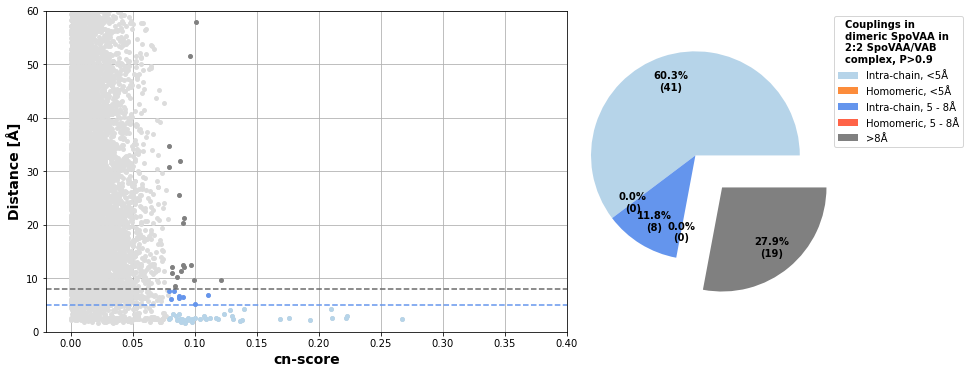

In [12]:
# add the computed distances to the coupling table and plot the data
tbl_cc = coupling_scores_compared(
    intra_A['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'], 
    DistanceMap.aggregate(
        monomer_distancemaps['spoVAAB_2_2.pdb/A'],
        monomer_distancemaps['spoVAAB_2_2.pdb/B'], 
    ),
    dist_map_multimer = agg_intra_distancemapA,
    dist_cutoff=dist_thresh
)

fig = plt.figure(figsize=(13, 5))
ax1,ax2 = fig.subplots(1,2,gridspec_kw={'width_ratios': [2, 1]})

tbl_cc = Pthresh(tbl_cc,0) # exclude all couplings P<0
idx = tbl_cc['dist_intra']<=tbl_cc['dist_multimer']
tbl_monomer = Pthresh(tbl_cc[idx],Pcutoff)
tbl_multimer = Pthresh(tbl_cc[~idx],Pcutoff)

#indexing for coloring - separate table into multimer contacts and monomer contacts
idx = Pthresh(tbl_cc,0)['dist_intra']<=Pthresh(tbl_cc,0)['dist_multimer']
tbl_monomer = Pthresh(tbl_cc[idx],Pcutoff)
tbl_multimer = Pthresh(tbl_cc[~idx],Pcutoff)

#threshold lines for distance threshold and cn-score threshold
ax1.axhline(y=dist_thresh, color="cornflowerblue", linestyle='--',)
ax1.axhline(y=dist_thresh_large, color="dimgrey", linestyle='--')

#index based on distance threshold to color
idx_dist_thresh_monomer = Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh

idx_dist_thresh_large_monomer = (Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh_large) & \
        (dist_thresh<Pthresh(tbl_monomer,Pcutoff)['dist'])

idx_unsatisfied_monomer = Pthresh(tbl_monomer,Pcutoff)['dist']>dist_thresh_large

idx_dist_thresh_multimer = Pthresh(tbl_multimer,Pcutoff)['dist']<=dist_thresh

idx_dist_thresh_large_multimer = (Pthresh(tbl_multimer,Pcutoff)['dist']<=dist_thresh_large) & \
        (dist_thresh<Pthresh(tbl_multimer,Pcutoff)['dist'])

idx_unsatisfied_multimer = Pthresh(tbl_multimer,Pcutoff)['dist']>dist_thresh_large

# scatter plots for couplings, cn-score vs. distance
ax1.scatter(Pthresh(tbl_cc,0)['cn'],
            Pthresh(tbl_cc,0)['dist'], s=15, c="gainsboro")

ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_monomer]['dist'], 
           s=15, c="#b6d4e9")
ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large_monomer]['dist'], 
           s=15, c="cornflowerblue")
ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied_monomer]['dist'], 
           s=15, c="grey")

ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_multimer]['dist'], 
           s=15, c="#fc8c3b")
ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_large_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_large_multimer]['dist'], 
           s=15, c="tomato")
ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_unsatisfied_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_unsatisfied_multimer]['dist'], 
           s=15, c="grey")

# some custom gusto with the axis labelling
ax1.set_xlabel('cn-score', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Distance [Å]', fontsize = 14, fontweight = 'bold')

ax1.grid(True, which='major')
ax1.set_axisbelow(True)

ax1.set_xlim(-0.02,0.4)
ax1.set_ylim(0,60)

# evaluate percentage of couplings over distance thresholds at given probability cutoff and make pie plot

num_cc = len(Pthresh(tbl_cc,Pcutoff)['dist']) #total number of couplings with P>cutoff

#monomer couplings
idx_monomer_1 = tbl_monomer['dist']<=dist_thresh # number of couplings with dist under dist_thresh
num_cc_monomer_close1 = len(tbl_monomer[idx_monomer_1]['dist'])

idx_monomer_2 = (tbl_monomer['dist']<=dist_thresh_large) & \
                (dist_thresh<tbl_monomer['dist'])
num_cc_monomer_close2 = len(tbl_monomer[idx_monomer_2]['dist']) # number of couplings between dist_thresh & dist_thresh_large

idx_monomer_far = tbl_monomer['dist']>dist_thresh_large
num_cc_monomer_far = len(tbl_monomer[idx_monomer_far]['dist']) # number of couplings larger than dist_thresh_large

#multimer couplings
idx_multimer_1 = tbl_multimer['dist']<=dist_thresh # number of couplings with dist under dist_thresh
num_cc_multimer_close1 = len(tbl_multimer[idx_multimer_1]['dist'])

idx_multimer_2 = (tbl_multimer['dist']<=dist_thresh_large) & \
                (dist_thresh<tbl_multimer['dist'])
num_cc_multimer_close2 = len(tbl_multimer[idx_multimer_2]['dist']) # number of couplings between dist_thresh & 2xdist_thresh

idx_multimer_far = tbl_multimer['dist']>dist_thresh_large
num_cc_multimer_far = len(tbl_multimer[idx_multimer_far]['dist']) # number of couplings larger than 2xdist_thresh

ccs = [num_cc_monomer_close1,num_cc_multimer_close1,
       num_cc_monomer_close2,num_cc_multimer_close2,
       num_cc_monomer_far+num_cc_multimer_far] 
#add up the couplings that are far apart as it is unclear if those are mono- or multimeric contacts!

labellist = ('Intra-chain, <'+str(dist_thresh)+'Å',
             'Homomeric, <'+str(dist_thresh)+'Å',
             'Intra-chain, '+str(dist_thresh)+' - '+str(dist_thresh_large)+'Å',
             'Homomeric, '+str(dist_thresh)+' - '+str(dist_thresh_large)+'Å',
             '>'+str(dist_thresh_large)+'Å')

#plot as pie chart that contains ratios + total number of couplings in thresholds
#make pie plot with labels
wedges, texts, autotexts = ax2.pie(ccs, labels = None, explode = (0,0,0,0,0.4),
        startangle = 0, autopct = make_autopct(ccs), pctdistance=0.75,
        colors = ["#b6d4e9","#fc8c3b","cornflowerblue","tomato","grey"])
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

#add a legend with color legend
ax2.legend(wedges, labellist,
          title="Couplings in \ndimeric SpoVAA in \n2:2 SpoVAA/VAB \ncomplex, P>"+str(Pcutoff),
          title_fontproperties={'weight':'bold', 'size':10},
          loc="upper right",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold", color = 'black')

fig.tight_layout(pad = 0, h_pad = 0, w_pad = 0) # tight padding in plot, no big gaps

In [13]:
# save the plot and coupling data
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Plots"
filename = "SpoVAA_2_2_statistics"
#enter without ending as it will save png and SVG

fileout = outpath+'/2_2/'+filename+'.png'
fig.savefig(fileout, bbox_inches='tight', dpi=300)
fileout_svg = outpath+'/SVG/'+filename+'.svg'
fig.savefig(fileout_svg, bbox_inches='tight', dpi=300)

In [23]:
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Coupling Data"
tbl_monomer.to_csv(outpath+'/SpoVAA_2_2_intra_couplings.csv',
                                    index = False, sep = ',')
tbl_multimer.to_csv(outpath+'/SpoVAA_2_2_inter_couplings.csv',
                                    index = False, sep = ',')

In [24]:
# provide list of chains in PDB file to map couplings on
chainlist = ["A","B"]
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/"

# get the i to j couplings and write to file that can be loaded into ChimeraX

with open(outpath+'/SpoVAA_2_2_intra_couplings_plot_all.cxc', 'w') as txtfile:
    
    #preformatting
    txtfile.write("""# ChimeraX script: Plot monomer couplings on SpoVAA in 2:2 SpoVAA-VAB complex
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Monomer couplings P>0.9 sorted by cn-score""")
    
    for jdx in list(tbl_monomer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if tbl_monomer['dist'][jdx]<=dist_thresh:
            txtfile.write("\n")
            col = "#B6D4E9"
            arg = 'CONTACT_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
        elif (tbl_monomer['dist'][jdx]<=dist_thresh_large) & \
        (dist_thresh<tbl_monomer['dist'][jdx]):
            txtfile.write("\n")
            col = "#6495ED"
            arg = 'CONTACT_FAR_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
        elif Pthresh(tbl_monomer,Pcutoff)['dist'][jdx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
    txtfile.write("\nhide H")

with open(outpath+'/SpoVAA_2_2_inter_couplings_plot_all.cxc', 'w') as txtfile:                
                
    #preformatting
    txtfile.write("""# ChimeraX script: Plot multimeric couplings on SpoVAA in 2:2 SpoVAA-VAB complex
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Multimer couplings P>0.9 sorted by cn-score""")               
       
    for jdx in list(tbl_multimer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if tbl_multimer['dist'][jdx]<=dist_thresh:
            txtfile.write("\n")
            col = "#FC8C3B"
            arg = 'CONTACT_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
            
        elif (tbl_multimer['dist'][jdx]<=dist_thresh_large) & \
        (dist_thresh<tbl_multimer['dist'][jdx]):
            txtfile.write("\n")
            col = "tomato"
            arg = 'CONTACT_FAR_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
            
        elif tbl_multimer['dist'][jdx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
    
    txtfile.write("\nhide H")

print('Commands written to files in '+outpath)

Commands written to files in S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/


## SpoVAB

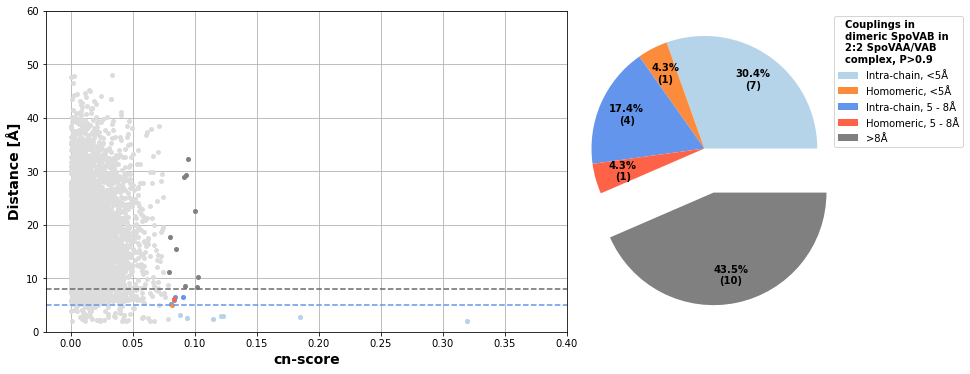

In [14]:
# add the computed distances to the coupling table and plot the data
tbl_cc = coupling_scores_compared(
    intra_B['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'], 
    DistanceMap.aggregate(
        monomer_distancemaps['spoVAAB_2_2.pdb/C'],
        monomer_distancemaps['spoVAAB_2_2.pdb/D'], 
    ),
    dist_map_multimer = agg_intra_distancemapB,
    dist_cutoff=dist_thresh
)

fig = plt.figure(figsize=(13, 5))
ax1,ax2 = fig.subplots(1,2,gridspec_kw={'width_ratios': [2, 1]})

tbl_cc = Pthresh(tbl_cc,0) # exclude all couplings P<0
idx = tbl_cc['dist_intra']<=tbl_cc['dist_multimer']
tbl_monomer = Pthresh(tbl_cc[idx],Pcutoff)
tbl_multimer = Pthresh(tbl_cc[~idx],Pcutoff)

#threshold lines for distance threshold and cn-score threshold
ax1.axhline(y=dist_thresh, color="cornflowerblue", linestyle='--',)
ax1.axhline(y=dist_thresh_large, color="dimgrey", linestyle='--')

#index based on distance threshold to color
idx_dist_thresh_monomer = Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh

idx_dist_thresh_large_monomer = (Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh_large) & \
        (dist_thresh<Pthresh(tbl_monomer,Pcutoff)['dist'])

idx_unsatisfied_monomer = Pthresh(tbl_monomer,Pcutoff)['dist']>dist_thresh_large

idx_dist_thresh_multimer = Pthresh(tbl_multimer,Pcutoff)['dist']<=dist_thresh

idx_dist_thresh_large_multimer = (Pthresh(tbl_multimer,Pcutoff)['dist']<=dist_thresh_large) & \
        (dist_thresh<Pthresh(tbl_multimer,Pcutoff)['dist'])

idx_unsatisfied_multimer = Pthresh(tbl_multimer,Pcutoff)['dist']>dist_thresh_large

# scatter plots for couplings, cn-score vs. distance
ax1.scatter(Pthresh(tbl_cc,0)['cn'],
            Pthresh(tbl_cc,0)['dist'], s=15, c="gainsboro")

ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_monomer]['dist'], 
           s=15, c="#b6d4e9")
ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large_monomer]['dist'], 
           s=15, c="cornflowerblue")
ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied_monomer]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied_monomer]['dist'], 
           s=15, c="grey")

ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_multimer]['dist'], 
           s=15, c="#fc8c3b")
ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_large_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_dist_thresh_large_multimer]['dist'], 
           s=15, c="tomato")
ax1.scatter(Pthresh(tbl_multimer,Pcutoff)[idx_unsatisfied_multimer]['cn'],
            Pthresh(tbl_multimer,Pcutoff)[idx_unsatisfied_multimer]['dist'], 
           s=15, c="grey")

# some custom gusto with the axis labelling
ax1.set_xlabel('cn-score', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Distance [Å]', fontsize = 14, fontweight = 'bold')

ax1.grid(True, which='major')
ax1.set_axisbelow(True)

ax1.set_xlim(-0.02,0.4)
ax1.set_ylim(0,60)

# evaluate percentage of couplings over distance thresholds at given probability cutoff and make pie plot

num_cc = len(Pthresh(tbl_cc,Pcutoff)['dist']) #total number of couplings with P>cutoff

#monomer couplings
idx_monomer_1 = tbl_monomer['dist']<=dist_thresh # number of couplings with dist under dist_thresh
num_cc_monomer_close1 = len(tbl_monomer[idx_monomer_1]['dist'])

idx_monomer_2 = (tbl_monomer['dist']<=dist_thresh_large) & \
                (dist_thresh<tbl_monomer['dist'])
num_cc_monomer_close2 = len(tbl_monomer[idx_monomer_2]['dist']) # number of couplings between dist_thresh & dist_thresh_large

idx_monomer_far = tbl_monomer['dist']>dist_thresh_large
num_cc_monomer_far = len(tbl_monomer[idx_monomer_far]['dist']) # number of couplings larger than dist_thresh_large

#multimer couplings
idx_multimer_1 = tbl_multimer['dist']<=dist_thresh # number of couplings with dist under dist_thresh
num_cc_multimer_close1 = len(tbl_multimer[idx_multimer_1]['dist'])

idx_multimer_2 = (tbl_multimer['dist']<=dist_thresh_large) & \
                (dist_thresh<tbl_multimer['dist'])
num_cc_multimer_close2 = len(tbl_multimer[idx_multimer_2]['dist']) # number of couplings between dist_thresh & 2xdist_thresh

idx_multimer_far = tbl_multimer['dist']>dist_thresh_large
num_cc_multimer_far = len(tbl_multimer[idx_multimer_far]['dist']) # number of couplings larger than 2xdist_thresh

ccs = [num_cc_monomer_close1,num_cc_multimer_close1,
       num_cc_monomer_close2,num_cc_multimer_close2,
       num_cc_monomer_far+num_cc_multimer_far] 
#add up the couplings that are far apart as it is unclear if those are mono- or multimeric contacts!

labellist = ('Intra-chain, <'+str(dist_thresh)+'Å',
             'Homomeric, <'+str(dist_thresh)+'Å',
             'Intra-chain, '+str(dist_thresh)+' - '+str(dist_thresh_large)+'Å',
             'Homomeric, '+str(dist_thresh)+' - '+str(dist_thresh_large)+'Å',
             '>'+str(dist_thresh_large)+'Å')

#plot as pie chart that contains ratios + total number of couplings in thresholds
#make pie plot with labels
wedges, texts, autotexts = ax2.pie(ccs, labels = None, explode = (0,0,0,0,0.4),
        startangle = 0, autopct = make_autopct(ccs), pctdistance=0.75,
        colors = ["#b6d4e9","#fc8c3b","cornflowerblue","tomato","grey"])
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

#add a legend with color legend
ax2.legend(wedges, labellist,
          title="Couplings in \ndimeric SpoVAB in \n2:2 SpoVAA/VAB \ncomplex, P>"+str(Pcutoff),
          title_fontproperties={'weight':'bold', 'size':10},
          loc="upper right",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold", color = 'black')

fig.tight_layout(pad = 0, h_pad = 0, w_pad = 0) # tight padding in plot, no big gaps

In [15]:
# save the plot and coupling data
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Plots"
filename = "SpoVAB_2_2_statistics" #enter without ending as it will save png and SVG

fileout = outpath+'/2_2/'+filename+'.png'
fig.savefig(fileout, bbox_inches='tight', dpi=300)
fileout_svg = outpath+'/SVG/'+filename+'.svg'
fig.savefig(fileout_svg, bbox_inches='tight', dpi=300)

In [29]:
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Coupling Data"
tbl_monomer.to_csv(outpath+'/SpoVAB_2_2_intra_couplings.csv',
                                    index = False, sep = ',')
tbl_multimer.to_csv(outpath+'/SpoVAB_2_2_inter_couplings.csv',
                                    index = False, sep = ',')

In [30]:
# provide list of chains in PDB file to map couplings on
chainlist = ["C","D"]
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/"

# get the i to j couplings and write to file that can be loaded into ChimeraX

with open(outpath+'/SpoVAB_2_2_intra_couplings_plot_all.cxc', 'w') as txtfile:
    
    #preformatting
    txtfile.write("""# ChimeraX script: Plot monomer couplings on SpoVAB in 2:2 SpoVAA-VAB complex
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Monomer couplings P>0.9 sorted by cn-score""")
    
    for jdx in list(tbl_monomer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if tbl_monomer['dist'][jdx]<=dist_thresh:
            txtfile.write("\n")
            col = "#B6D4E9"
            arg = 'CONTACT_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
        elif (tbl_monomer['dist'][jdx]<=dist_thresh_large) & \
        (dist_thresh<tbl_monomer['dist'][jdx]):
            txtfile.write("\n")
            col = "#6495ED"
            arg = 'CONTACT_FAR_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
        elif Pthresh(tbl_monomer,Pcutoff)['dist'][jdx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED_MONOMER'
            for chain in chainlist:
                txtfile.write(writerfun(tbl_monomer,jdx,chain,chain,col,arg,flg))
                flg = False
            txtfile.write(showfun(tbl_monomer['i'][jdx],tbl_monomer['j'][jdx],chainlist))
            
    txtfile.write("\nhide H")

with open(outpath+'/SpoVAB_2_2_inter_couplings_plot_all.cxc', 'w') as txtfile:                
                
    #preformatting
    txtfile.write("""# ChimeraX script: Plot multimeric couplings on SpoVAB in 2:2 SpoVAA-VAB complex
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Multimer couplings P>0.9 sorted by cn-score""")               
       
    for jdx in list(tbl_multimer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if tbl_multimer['dist'][jdx]<=dist_thresh:
            txtfile.write("\n")
            col = "#FC8C3B"
            arg = 'CONTACT_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
            
        elif (tbl_multimer['dist'][jdx]<=dist_thresh_large) & \
        (dist_thresh<tbl_multimer['dist'][jdx]):
            txtfile.write("\n")
            col = "tomato"
            arg = 'CONTACT_FAR_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
            
        elif tbl_multimer['dist'][jdx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED_MULTIMER'
            for chain in chainlist:
                chainlist_filter = chainlist[:]
                chainlist_filter.remove(chain)
                for secondchain in chainlist_filter:
                    txtfile.write(writerfun(tbl_multimer,jdx,chain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_multimer['i'][jdx],tbl_multimer['j'][jdx],chainlist))
    
    txtfile.write("\nhide H")

print('Commands written to files in '+outpath)

Commands written to files in S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/


## SpoVAA-SpoVAB


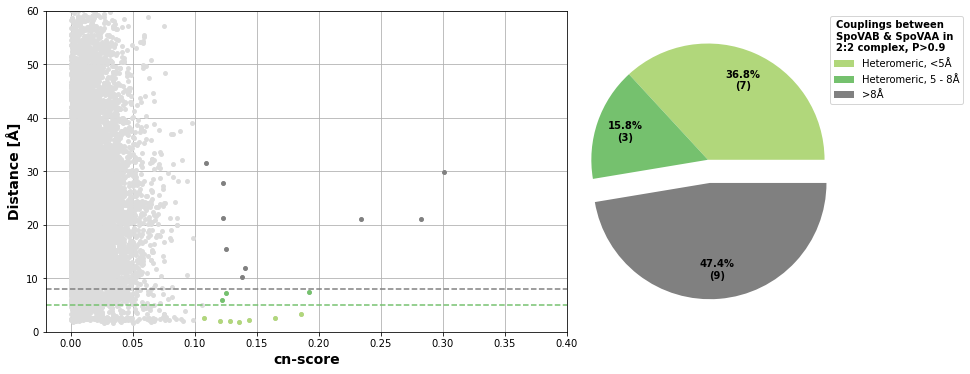

In [16]:
# add the computed distances to the coupling table and plot the data
tbl_cc = coupling_scores_compared(
    inter['20220622_spoVAA_VAB/couplings/20220621_spoVAAB_existingalignment_CouplingScores_longrange.csv'], 
    agg_inter_distancemap, 
    dist_map_multimer = None,
    dist_cutoff=dist_thresh
)

fig = plt.figure(figsize=(13, 5))
ax1,ax2 = fig.subplots(1,2,gridspec_kw={'width_ratios': [2, 1]})

tbl_monomer = Pthresh(tbl_cc,Pcutoff)

#threshold lines for distance threshold and cn-score threshold
ax1.axhline(y=dist_thresh, color="#75C16E", linestyle='--')
ax1.axhline(y=dist_thresh_large, color="grey", linestyle='--')

# index based on distance threshold
idx_dist_thresh = Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh

idx_dist_thresh_large = (Pthresh(tbl_monomer,Pcutoff)['dist']<=dist_thresh_large) & \
        (dist_thresh<Pthresh(tbl_monomer,Pcutoff)['dist'])

idx_unsatisfied = Pthresh(tbl_monomer,Pcutoff)['dist']>dist_thresh_large

ax1.scatter(Pthresh(tbl_cc,0)['cn'],
            Pthresh(tbl_cc,0)['dist'], s=15, c="gainsboro")

ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh]['dist'], 
           s=15, c="#B1D77B")
ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_dist_thresh_large]['dist'], 
           s=15, c="#75C16E")
ax1.scatter(Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied]['cn'],
            Pthresh(tbl_monomer,Pcutoff)[idx_unsatisfied]['dist'], 
           s=15, c="grey")

# some custom gusto with the axis labelling
ax1.set_xlabel('cn-score', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Distance [Å]', fontsize = 14, fontweight = 'bold')

ax1.grid(True, which='major')
ax1.set_axisbelow(True)

ax1.set_xlim(-0.02,0.4)
ax1.set_ylim(0,60)

# evaluate percentage of couplings over distance thresholds at given probability cutoff and make pie plot

num_cc = len(tbl_monomer['dist']) #total number of couplings with P>cutoff

idx1 = tbl_monomer['dist']<=dist_thresh # number of couplings with dist under dist_thresh
num_cc_close1 = len(tbl_monomer[idx1]['dist'])

idx2 = (tbl_monomer['dist']<=dist_thresh_large) & \
       (dist_thresh<tbl_monomer['dist'])
num_cc_close2 = len(tbl_monomer[idx2]['dist']) # number of couplings between dist_thresh & 2xdist_thresh

idx_far = tbl_monomer['dist']>dist_thresh_large
num_cc_far = len(tbl_monomer[idx_far]['dist']) # number of couplings larger than 2xdist_thresh

ccs = [num_cc_close1,num_cc_close2,num_cc_far]
labellist = ('Heteromeric, <'+str(dist_thresh)+'Å',
             'Heteromeric, '+str(dist_thresh)+' - '+str(dist_thresh_large)+'Å',
             '>'+str(dist_thresh_large)+'Å')

#plot as pie chart that contains ratios + total number of couplings in thresholds
#make pie plot with labels
wedges, texts, autotexts = ax2.pie(ccs, labels = None, explode = (0,0,0.2),
        startangle = 0, autopct = make_autopct(ccs), pctdistance=0.75,
        colors = ["#B1D77B","#75C16E","grey"])
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

#add a legend with color legend
ax2.legend(wedges, labellist,
          title="Couplings between \nSpoVAB & SpoVAA in \n2:2 complex, P>"+str(Pcutoff),
          title_fontproperties={'weight':'bold', 'size':10},
          loc="upper right",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold", color = 'black')

fig.tight_layout(pad = 0, h_pad = 0, w_pad = 0) # tight padding in plot, no big gaps

plt.show()

In [17]:
# save the plot and coupling data
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Plots"
filename = "SpoVAA_SpoVAB_inter_2_2_statistics"
#enter without ending as it will save png and SVG

fileout = outpath+'/2_2/'+filename+'.png'
fig.savefig(fileout, bbox_inches='tight', dpi=300)
fileout_svg = outpath+'/SVG/'+filename+'.svg'
fig.savefig(fileout_svg, bbox_inches='tight', dpi=300)

In [35]:
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/Coupling Data"
Pthresh(tbl_monomer,Pcutoff).to_csv(outpath+'/SpoVAA_SpoVAB_inter_2_2_couplings.csv',
                                    index = False, sep = ',')

In [36]:
outpath = "S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/ChimeraX scripts"
# provide chainlists
chainlist1 = ["A","B"]
chainlist2 = ["C","D"]

# write the computed couplings to python command script for ChimeraX plotting
# get the i to j couplings and write to file that can be loaded into ChimeraX

with open(outpath+'/SpoVAA_SpoVAB_inter_2_2_couplings_plot_all.cxc', 'w') as txtfile:
    
    #preformatting
    txtfile.write("""# ChimeraX script: Plot couplings between SpoVAA-SpoVAB in 2:2 SpoVAA:SpoVAB complex
show cartoons
color bychain
color byhetero
style stick
graphics silhouettes true color black
lighting soft

# Monomer couplings between SpoVAA-SpoVAB P>0.9 sorted by cn-score""")
    
    for idx in list(tbl_monomer.index):  
        flg = True #flag to write header on first line only
        
        #coloring based on distance as in pie chart        
        if Pthresh(tbl_monomer,Pcutoff)['dist'][idx]<=dist_thresh:
            txtfile.write("\n")
            col = "#B1D77B"
            arg = 'CONTACT'
            for firstchain in chainlist1:
                for secondchain in chainlist2:
                    txtfile.write(writerfun(tbl_monomer,idx,firstchain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_monomer['i'][idx],tbl_monomer['i'][idx],chainlist1))
            txtfile.write(showfun(tbl_monomer['j'][idx],tbl_monomer['j'][idx],chainlist2))
            
        elif (tbl_monomer['dist'][idx]<=dist_thresh_large) & \
        (dist_thresh<tbl_monomer['dist'][idx]):
            txtfile.write("\n")
            col = "#75C16E"
            arg = 'CONTACT_FAR'
            for firstchain in chainlist1:
                for secondchain in chainlist2:
                    txtfile.write(writerfun(tbl_monomer,idx,firstchain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_monomer['i'][idx],tbl_monomer['i'][idx],chainlist1))
            txtfile.write(showfun(tbl_monomer['j'][idx],tbl_monomer['j'][idx],chainlist2))
            
        elif tbl_monomer['dist'][idx]>dist_thresh_large:
            txtfile.write("\n")
            col = "grey"
            arg = 'UNSATISFIED'
            for firstchain in chainlist1:
                for secondchain in chainlist2:
                    txtfile.write(writerfun(tbl_monomer,idx,firstchain,secondchain,col,arg,flg))
                    flg = False #set to false to avoid re-printing header
            txtfile.write(showfun(tbl_monomer['i'][idx],tbl_monomer['i'][idx],chainlist1))
            txtfile.write(showfun(tbl_monomer['j'][idx],tbl_monomer['j'][idx],chainlist2))
        
    txtfile.write("hide H")
    
print('Commands written to files in '+outpath)    

Commands written to files in S:/Max/Documents/#STUDIUM/#MSc/#Masterarbeit_Bischofs/Bioinformatics/EVCouplings mapped on Alphafold complexes/spoVAAB_multimer/ChimeraX scripts
